# How is the concentration of PM2.5 associated with asthmatic attacks across the United States?

## install libraries

In [ ]:
pip install pandas
pip install matplotlib
pip install geopandas
pip install imageio
pip install statsmodels

## Import Libraries

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import imageio
import os
import statsmodels.api as sm

## Data Pre-processing

### Read and Merge Data

In [21]:
# read three datasets from csv

data_asthma = pd.read_csv('asthma_all.csv')
data_pm = pd.read_csv('pmdata_all.csv')
data_county = pd.read_csv('states_county_FIPS.csv')

# drop redundant columns

data_asthma = data_asthma.drop('Unnamed: 0', axis = 1)
data_pm = data_pm.drop('Unnamed: 0', axis = 1)
data_county = data_county.drop('Unnamed: 0', axis = 1)

In [22]:
# merge three datasets together

data = pd.merge(data_asthma, data_pm, on = ['State FIPS Code', 'County FIPS Code', 'Year'])
data = pd.merge(data, data_county, on = ['State FIPS Code', 'County FIPS Code']) # county datasets will be used for visualization
data = data.drop(['State Name_x', 'County Name_x', 'Alpha Code'], axis = 1) # drop names inconsistent with map data in visualization part
data = data.drop_duplicates()
data.columns = ['State FIPS Code', 'County FIPS Code', 'Year', 'EDvisit', 'PM2.5', 'State Name', 'County Name']
data

,State FIPS Code,County FIPS Code,Year,EDvisit,PM2.5,State Name,County Name
0,19,13,2011,635,29.8,Iowa,Black Hawk County
2,19,13,2012,769,24.0,Iowa,Black Hawk County
4,19,13,2013,643,34.1,Iowa,Black Hawk County
6,19,13,2014,689,23.4,Iowa,Black Hawk County
8,19,13,2015,636,32.4,Iowa,Black Hawk County
...,...,...,...,...,...,...,...
4716,47,165,2015,834,17.9,Tennessee,Sumner County
4718,47,165,2016,730,28.4,Tennessee,Sumner County
4720,47,165,2017,704,129.0,Tennessee,Sumner County
4722,47,165,2018,725,106.0,Tennessee,Sumner County


### Clean Missing Value

In [23]:
# Check missing value in ED visits


def f(x): # change missing value to None type
    if x == 'Suppressed':
        x = None
    if x != None:
        x = x.replace(',', '')
        x = float(x)
    return x

data['EDvisit'] = data['EDvisit'].apply(f)

# drop missing value

data = data.dropna()

print(data.isnull().sum())

State FIPS Code     0
County FIPS Code    0
Year                0
EDvisit             0
PM2.5               0
State Name          0
County Name         0
dtype: int64


### Code for Control Variables 

Notes: Categorized by the newest statistical data and available states data
```
1. Geographic regions: northeast, midwest, south, west
2. Economic status: high, medium, low
3. Population density: high, medium, low
```

In [24]:
# Geographic Regions
def f(x):
    northeast = ['Maine', 'Vermont', 'Massachusetts', 'Connecticut', 'Rhode Island', 'New York', 'New Jersey']
    midwest = ['Iowa', 'Minnesota', 'Wisconsin', 'Missouri', 'Kansas']
    south = ['Kentucky', 'Tennessee', 'North Carolina', 'Louisiana', 'Florida']
    west = ['California', 'New Mexico', 'Utah', 'Arizona']
    if x in northeast:
        region = 1
    if x in midwest:
        region = 2
    if x in south:
        region = 3
    if x in west:
        region = 4
    return region

data['Region'] = data['State Name'].apply(f)

/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/145219901.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Region'] = data['State Name'].apply(f)


In [25]:
# Economic Status
def f(x):
    high = ['California','New York','Massachusetts','Connecticut','New Jersey']
    medium = ['Iowa', 'Minnesota', 'Wisconsin', 'Missouri','Arizona' ,'Kentucky', 'Tennessee', 'North Carolina', 'Louisiana', 'Florida','Vermont','Kansas']
    low = ['New Mexico', 'Utah', 'Maine','Rhode Island']
    if x in low:
        eco = 1
    if x in medium:
        eco = 2
    if x in high:
        eco = 3
    return eco

data['Economics'] = data['State Name'].apply(f)

/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/2213720222.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Economics'] = data['State Name'].apply(f)


In [26]:
# Population
def f(x):
    high = ['Massachusetts','Rhode Island']
    medium = ['California','New York', 'New Jersey','Minnesota', 'Wisconsin', 'Missouri','Kentucky', 'Tennessee', 'North Carolina', 'Louisiana', 'Florida','Kansas']
    low = ['New Mexico', 'Utah', 'Maine','Vermont', 'Arizona','Iowa','Connecticut']
    if x in low:
        population = 1
    if x in medium:
        population = 2
    if x in high:
        population = 3
    return population

data['Population'] = data['State Name'].apply(f)

/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/1581527412.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Population'] = data['State Name'].apply(f)


In [27]:
data

,State FIPS Code,County FIPS Code,Year,EDvisit,PM2.5,State Name,County Name,Region,Economics,Population
0,19,13,2011,635.0,29.8,Iowa,Black Hawk County,2,2,1
2,19,13,2012,769.0,24.0,Iowa,Black Hawk County,2,2,1
4,19,13,2013,643.0,34.1,Iowa,Black Hawk County,2,2,1
6,19,13,2014,689.0,23.4,Iowa,Black Hawk County,2,2,1
8,19,13,2015,636.0,32.4,Iowa,Black Hawk County,2,2,1
...,...,...,...,...,...,...,...,...,...,...
4716,47,165,2015,834.0,17.9,Tennessee,Sumner County,3,2,2
4718,47,165,2016,730.0,28.4,Tennessee,Sumner County,3,2,2
4720,47,165,2017,704.0,129.0,Tennessee,Sumner County,3,2,2
4722,47,165,2018,725.0,106.0,Tennessee,Sumner County,3,2,2


## Descriptive Results

### Overview

In [28]:
# descriptive results for overall ED visit and PM2.5 concentration data

ed_des = pd.DataFrame(data['EDvisit'].describe()).T
pm_des = pd.DataFrame(data['PM2.5'].describe()).T

In [29]:
ed_des

,count,mean,std,min,25%,50%,75%,max
EDvisit,2360.0,2552.461441,5181.728911,6.0,265.25,799.5,2835.25,51895.0


In [30]:
pm_des

,count,mean,std,min,25%,50%,75%,max
PM2.5,2360.0,72.905339,95.309656,4.3,23.775,40.0,84.175,1167.0


### States-level Data

In [31]:
# group by states

grouped_states = data.groupby(data['State Name'])
state_des = []

for year, content in grouped_states:
    ed_des_state = content['EDvisit'].describe().round().astype(int) # count per person
    pm_des_state = round(content['PM2.5'].describe(), 2)
    year_state = year

    state_des.append([year_state, pm_des_state, ed_des_state])

# dataframe for annual descriptive results

state_des = pd.DataFrame(state_des, columns=['State Name', 'PM', 'Asthma'])

clean = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
pattern = '|'.join(clean)
state_des['PM'] = state_des['PM'].astype(str).str.replace(pattern, '')
state_des['Asthma'] = state_des['Asthma'].astype(str).str.replace(pattern, '')

# split into columns

state_des[['pm_count', 'pm_mean', 'pm_std', 'pm_min', 'pm_25%', 'pm_50%', 'pm_75%', 'pm_max', 'type']] = state_des['PM'].str.split('\n', expand=True)
state_des[['ed_count', 'ed_mean', 'ed_std', 'ed_min', 'ed_25%', 'ed_50%', 'ed_75%', 'ed_max', 'type']] = state_des['Asthma'].str.split('\n', expand=True)

state_des = state_des.drop(['PM', 'Asthma', 'type', 'pm_count','pm_25%', 'pm_50%','pm_75%', 'ed_count','ed_25%', 'ed_50%', 'ed_75%'], axis = 1)

state_des = pd.merge(state_des, data[['State Name', 'Population']], on = 'State Name')

state_des = state_des.drop_duplicates()

state_des


/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/911988649.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  state_des['PM'] = state_des['PM'].astype(str).str.replace(pattern, '')
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/911988649.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  state_des['Asthma'] = state_des['Asthma'].astype(str).str.replace(pattern, '')


,State Name,pm_mean,pm_std,pm_min,pm_max,ed_mean,ed_std,ed_min,ed_max,Population
0,Arizona,156.45,198.66,4.30,1167.00,2796,5406,44,18957,1
80,California,122.35,127.86,5.50,985.00,3889,7587,43,51895,2
487,Connecticut,61.11,48.95,12.30,235.00,3779,2353,447,7461,1
532,Florida,42.58,49.47,13.10,448.00,5474,4397,439,18624,2
666,Iowa,37.19,46.19,16.30,461.00,440,526,8,2353,1
791,Kansas,65.84,77.09,18.20,357.60,1151,1173,6,3596,2
846,Kentucky,47.86,67.19,12.20,593.00,709,1390,49,6822,2
988,Louisiana,27.96,16.77,9.90,135.00,1204,1029,64,3863,2
1101,Maine,131.94,187.11,12.70,870.00,489,276,96,1167,1
1148,Massachusetts,65.28,57.12,12.20,253.70,3798,2192,371,7433,3


### Annual Data

In [32]:
# group by years

grouped_annual = data.groupby(data['Year'])
annual_des = []

for year, content in grouped_annual:
    ed_des_annual = content['EDvisit'].describe().round().astype(int) # count per person
    pm_des_annual = round(content['PM2.5'].describe(), 2)
    year_annual = year

    annual_des.append([year_annual, pm_des_annual, ed_des_annual])

# dataframe for annual descriptive results

annual_des = pd.DataFrame(annual_des, columns=['Year', 'PM', 'Asthma'])

clean = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
pattern = '|'.join(clean)
annual_des['PM'] = annual_des['PM'].astype(str).str.replace(pattern, '')
annual_des['Asthma'] = annual_des['Asthma'].astype(str).str.replace(pattern, '')

# split into columns

annual_des[['pm_count', 'pm_mean', 'pm_std', 'pm_min', 'pm_25%', 'pm_50%', 'pm_75%', 'pm_max', 'type']] = annual_des['PM'].str.split('\n', expand=True)
annual_des[['ed_count', 'ed_mean', 'ed_std', 'ed_min', 'ed_25%', 'ed_50%', 'ed_75%', 'ed_max', 'type']] = annual_des['Asthma'].str.split('\n', expand=True)

annual_des = annual_des.drop(['PM', 'Asthma', 'type','pm_count', 'ed_count'], axis = 1)

annual_des = annual_des.astype(float)

annual_des


/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/2773804442.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  annual_des['PM'] = annual_des['PM'].astype(str).str.replace(pattern, '')
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/2773804442.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  annual_des['Asthma'] = annual_des['Asthma'].astype(str).str.replace(pattern, '')


,Year,pm_mean,pm_std,pm_min,pm_25%,pm_50%,pm_75%,pm_max,ed_mean,ed_std,ed_min,ed_25%,ed_50%,ed_75%,ed_max
0,2011.0,52.56,68.65,4.6,25.65,31.20,56.55,768.4,2626.0,5312.0,11.0,287.0,870.0,2951.0,47510.0
1,2012.0,53.43,81.25,7.3,22.00,28.20,50.10,801.0,2890.0,5674.0,6.0,329.0,969.0,3221.0,49391.0
2,2013.0,62.01,96.32,9.7,20.95,27.75,61.02,914.0,2649.0,5457.0,8.0,310.0,826.0,2780.0,49732.0
3,2014.0,66.15,116.90,7.3,22.50,33.15,64.88,1167.0,2718.0,5479.0,7.0,308.0,854.0,3088.0,50771.0
4,2015.0,68.51,88.14,6.5,21.60,32.80,89.52,985.0,2633.0,5389.0,19.0,292.0,832.0,2898.0,51895.0
5,2016.0,75.86,93.09,8.7,22.78,47.50,89.20,804.0,2454.0,5141.0,8.0,236.0,726.0,2714.0,50479.0
6,2017.0,92.88,111.36,5.5,27.00,56.00,114.00,918.0,2428.0,4909.0,7.0,216.0,770.0,2742.0,49376.0
7,2018.0,99.02,100.92,4.3,35.65,62.00,129.35,870.0,2362.0,4711.0,8.0,212.0,719.0,2712.0,46612.0
8,2019.0,82.37,77.29,4.3,37.20,57.00,100.35,727.0,2240.0,4539.0,9.0,218.0,700.0,2544.0,46725.0


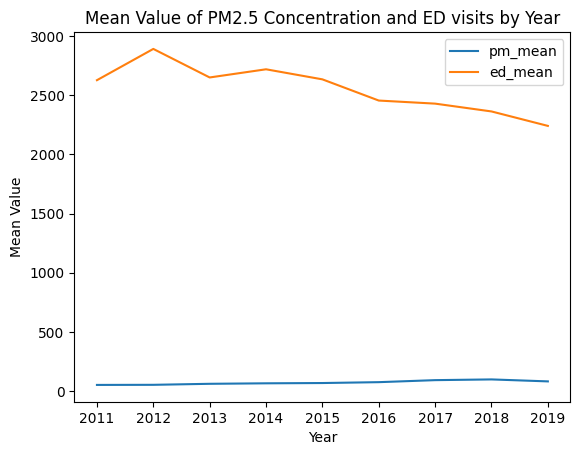

In [33]:
# line chart

plt.plot('Year', 'pm_mean', data = annual_des)
plt.plot('Year', 'ed_mean', data = annual_des)

plt.xlabel('Year')
plt.ylabel('Mean Value')
plt.title('Mean Value of PM2.5 Concentration and ED visits by Year')
plt.legend()

plt.show()

[None,
 Text(0.5, 1.0, 'Outliners of ED Visits for Asthma by Year'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'ED Visits')]

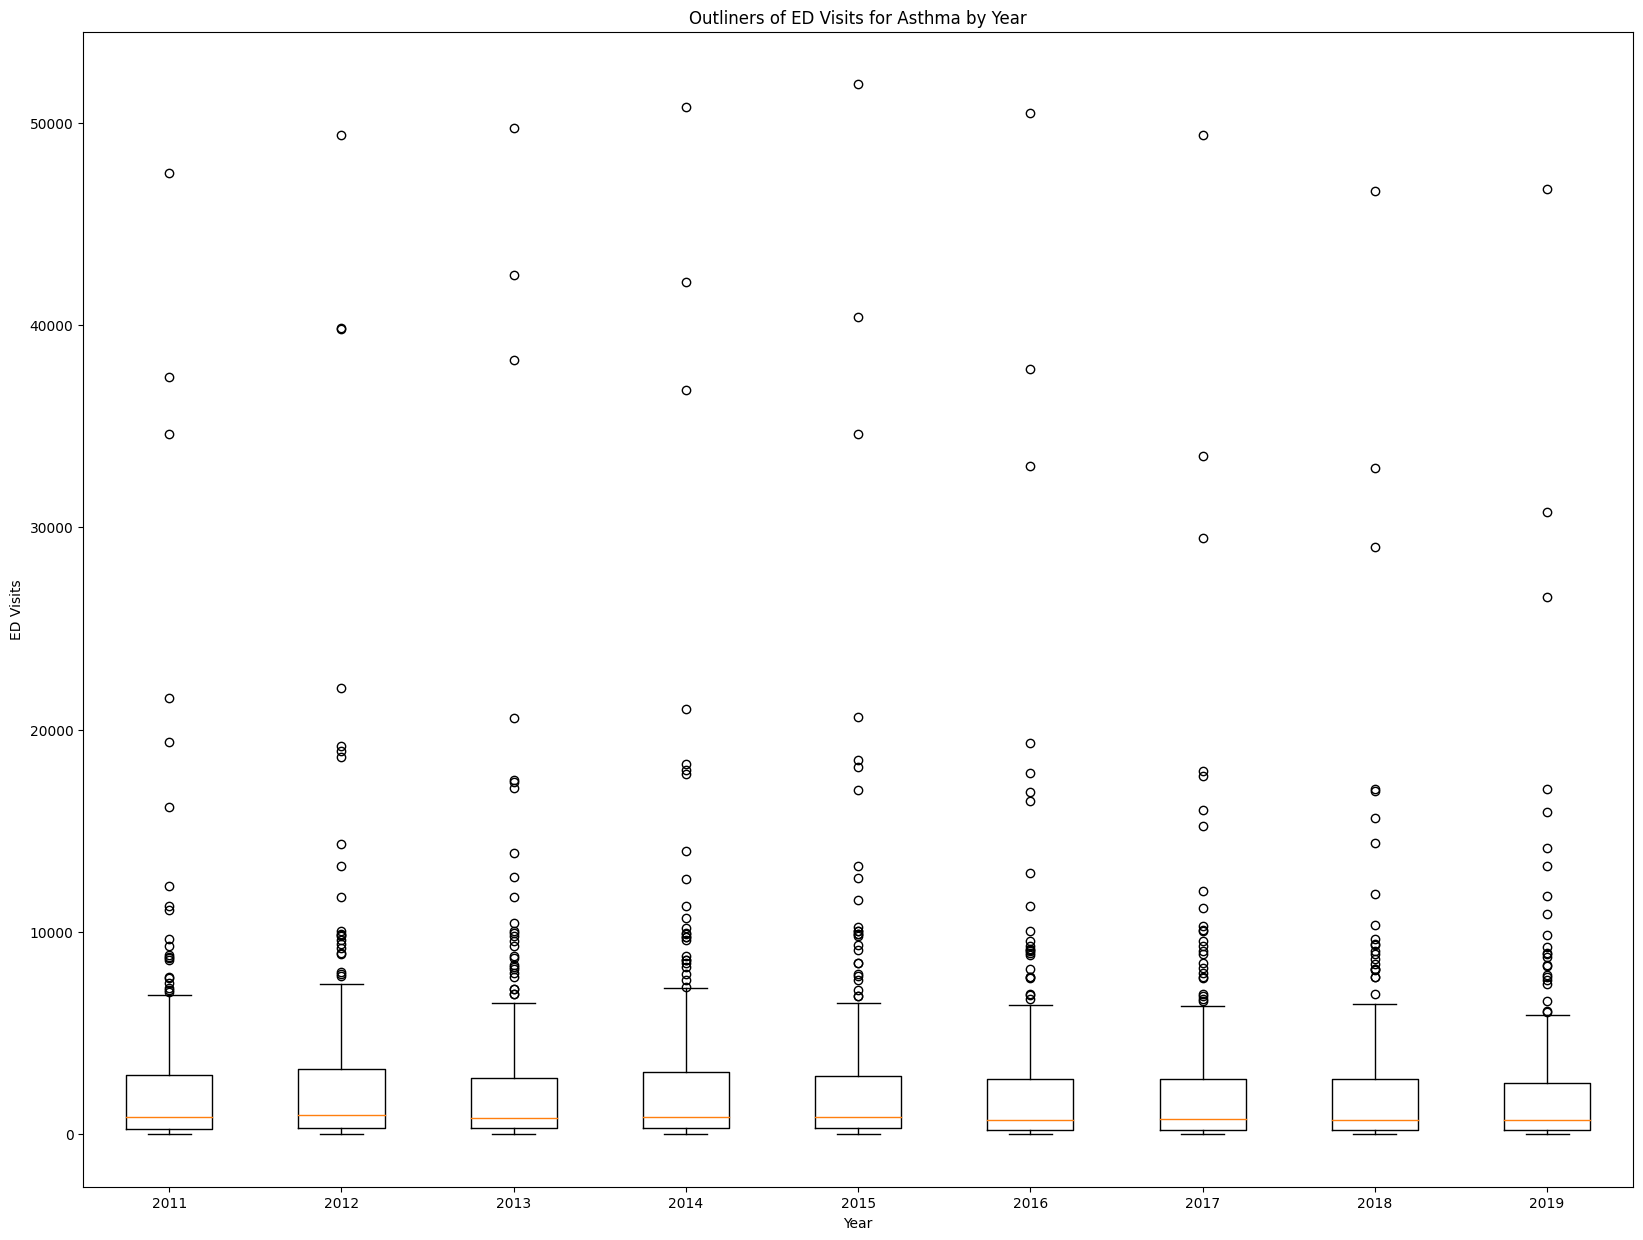

In [34]:
# outliners for ed visit

ed_value = []
for year, content in grouped_annual:
    edvisit = content['EDvisit'].values
    ed_value.append([year, edvisit])

ed_value = pd.DataFrame(ed_value, columns = ['Year', 'Values'])

    
fig, ax = plt.subplots(figsize = (20,15))

bp = ax.boxplot(ed_value['Values'], vert=True, labels = ed_value['Year'])
ax.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title='Outliners of ED Visits for Asthma by Year',
    xlabel='Year',
    ylabel='ED Visits',
) 


[None,
 Text(0.5, 1.0, 'Outliners of PM2.5 Concentration by Year'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'PM2.5 Concentration')]

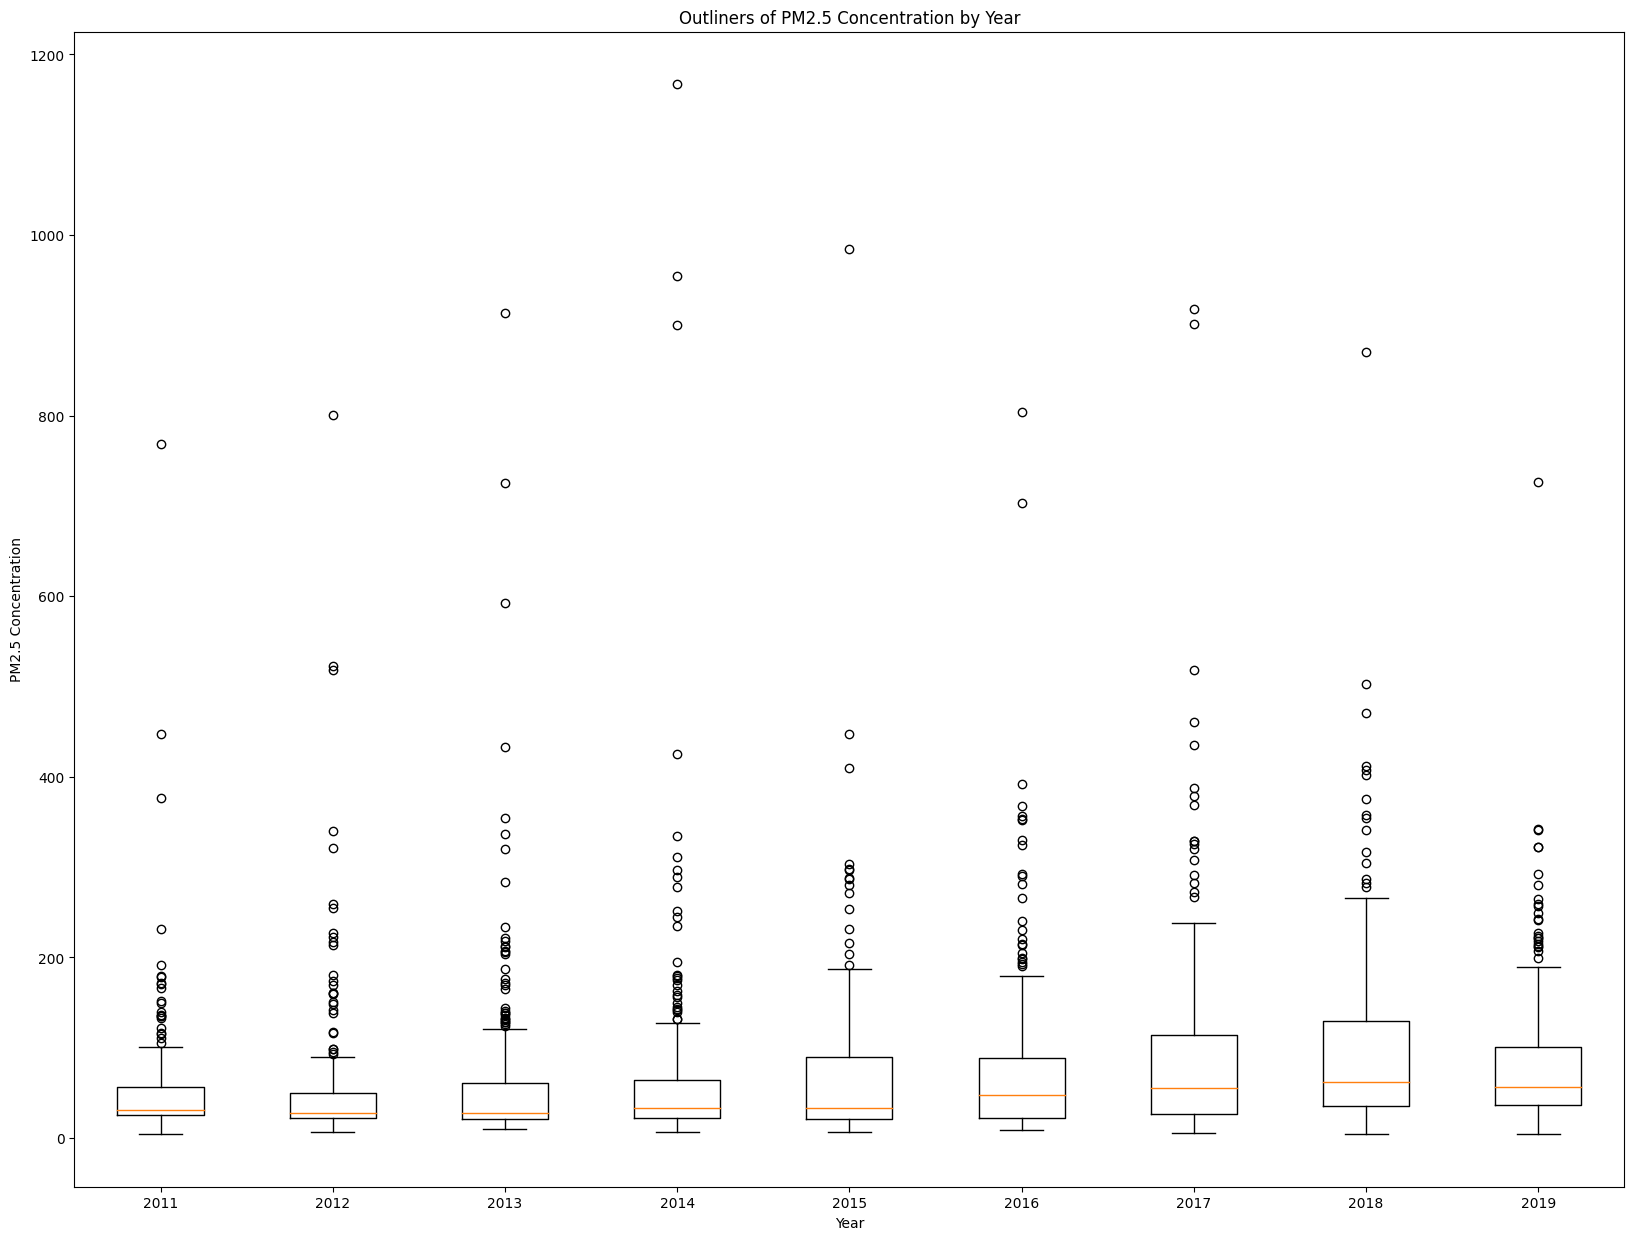

In [35]:
# outliners for pm2.5 concentration

pm_value = []
for year, content in grouped_annual:
    pmconcen = content['PM2.5'].values
    pm_value.append([year, pmconcen])

pm_value = pd.DataFrame(pm_value, columns = ['Year', 'Values'])

    
fig, ax = plt.subplots(figsize = (20,15))

bp = ax.boxplot(pm_value['Values'], vert=True, labels = pm_value['Year'])
ax.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title='Outliners of PM2.5 Concentration by Year',
    xlabel='Year',
    ylabel='PM2.5 Concentration',
) 


### Maps for Annual Trends by States

In [36]:
# group by year and state

grouped_state = data.groupby(['Year', 'State Name'])
state_des = []

for year, content in grouped_state:
    ed_des_state = content['EDvisit'].mean()
    pm_des_state = content['PM2.5'].mean()
    year_state = year[0]
    state_name = year[1]
    state_des.append([year_state, state_name, pm_des_state,  ed_des_state])

data_graph = pd.DataFrame(state_des, columns = ['Year', 'NAME', 'PM2.5 Concentration', 'ED Visit Number'])

data_graph


,Year,NAME,PM2.5 Concentration,ED Visit Number
0,2011,Arizona,58.350000,2471.800000
1,2011,California,95.765909,3980.386364
2,2011,Connecticut,33.580000,4408.400000
3,2011,Florida,448.000000,6583.000000
4,2011,Iowa,30.966667,455.333333
...,...,...,...,...
182,2019,Rhode Island,33.666667,1446.666667
183,2019,Tennessee,46.168750,1277.625000
184,2019,Utah,57.554545,520.818182
185,2019,Vermont,57.733333,214.000000


In [37]:
def generate_gif(data_for_graph, column_group, column_use, color, shapefile_path, output_path):
    # Load the shapefile of the US states
    usa = gpd.read_file(shapefile_path)

    # Load the ED visit data into a geopandas DataFrame
    data_input = gpd.GeoDataFrame(data_for_graph)

    # Merge the files
    data_figure = pd.merge(usa, data_input, on='NAME')

    # Get the unique grouping key in the data
    grouped = data_input[column_group].unique()

    # Initialize a list to store the filenames
    filenames = []

    # Loop through each year and generate a map
    for year in grouped:
        # Subset the data for the current year
        year_data = data_figure[data_figure[column_group] == year]

        # Create the map
        fig, ax = plt.subplots(figsize = (50, 50))

        # Plot the baseline map on the same axis as the year_data map
        usa.plot(ax = ax, alpha = 1, color = 'grey')

        # Plot the year_data map on the same axis as the baseline map
        # ax.legend(fontsize=50)
        year_data.plot(column = column_use, cmap = color, ax = ax, legend = True, legend_kwds = {'orientation': "horizontal"})

        fig = ax.figure
        cb_ax = fig.axes[1]
        cb_ax.tick_params(labelsize = 50)
        

        # Get the x and y limits from the year_data map
        xlim, ylim = (-127.36183095, -64.00561604999999), (23.14689945, 50.63388755)

        # Remove the axis labels and set the title
        ax.axis('off')
        ax.set_title(f'{column_use} in {year} by States', loc='center', fontsize=80)
        ax.set_xlabel('Latitude')
        ax.set_ylabel('Longitude')

        # Set the x and y limits for the axis
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        # Save the map as an image
        filename = f'{column_use}_{year}.png'
        plt.savefig(filename)
        filenames.append(filename)

        # Close the plot to free up memory
        plt.close()

    # Combine the images into a GIF using imageio
    with imageio.get_writer(output_path, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            # Set the frame duration to 2 seconds
            frame_duration = 3
            writer.append_data(image, frame_duration)

    # Remove the temporary image files
    for filename in filenames:
        os.remove(filename)


In [38]:
# dynamic graphs for pm2.5
generate_gif(data_for_graph = data_graph, column_group = 'Year', column_use = 'PM2.5 Concentration', color = 'Reds', shapefile_path = './tl_rd22_us_state/tl_rd22_us_state.shp', output_path = 'pm_concentration_annual.gif')

/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/1051109293.py:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/Users/siy/opt/anaconda3/envs/dsci510/lib/python3.11/site-packages/imageio/v2.py:203: UserWarning: V3 Plugins currently don't have a uniform way to write metadata, so any metadata is ignored.
  warnings.warn(


In [39]:
# dynamic graphs for ed visits
generate_gif(data_for_graph = data_graph, column_group = 'Year', column_use = 'ED Visit Number', color = 'Greens', shapefile_path = './tl_rd22_us_state/tl_rd22_us_state.shp', output_path = 'ed_visit_annual.gif')

/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/1051109293.py:61: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
/Users/siy/opt/anaconda3/envs/dsci510/lib/python3.11/site-packages/imageio/v2.py:203: UserWarning: V3 Plugins currently don't have a uniform way to write metadata, so any metadata is ignored.
  warnings.warn(


## Regression

### General Trend

In [40]:
results_notgrouped = pd.DataFrame(columns = [])

x = data['PM2.5']
Y = data['EDvisit']
X = sm.add_constant(x)
model_notgrouped = sm.OLS(Y, X).fit()

results_notgrouped = results_notgrouped.append({'Intercept': model_notgrouped.params[0], 'Slope': model_notgrouped.params[1], 'intercept_pvalue': model_notgrouped.pvalues[0], 'slope_pvalue': model_notgrouped.pvalues[1]}, ignore_index=True)

results_notgrouped['slope_significant'] = results_notgrouped['slope_pvalue'] < 0.05

print(model_notgrouped.summary())

                            OLS Regression Results                            
Dep. Variable:                EDvisit   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.435
Date:                Sat, 06 May 2023   Prob (F-statistic):             0.0353
Time:                        17:45:31   Log-Likelihood:                -23531.
No. Observations:                2360   AIC:                         4.707e+04
Df Residuals:                    2358   BIC:                         4.708e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2380.7248    134.205     17.740      0.0

/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/4116759098.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_notgrouped = results_notgrouped.append({'Intercept': model_notgrouped.params[0], 'Slope': model_notgrouped.params[1], 'intercept_pvalue': model_notgrouped.pvalues[0], 'slope_pvalue': model_notgrouped.pvalues[1]}, ignore_index=True)


### Annual Trend

/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/2225457852.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_annual = results_annual.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/2225457852.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_annual = results_annual.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/2225457852.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pa

,Year,Intercept,Slope,intercept_pvalue,slope_pvalue,slope_significant
0,2011.0,2324.982982,5.724203,2.228841e-07,0.257716,False
1,2012.0,2773.890683,2.166429,6.465885e-10,0.626113,False
2,2013.0,2741.635524,-1.487464,3.779498e-11,0.668752,False
3,2014.0,2481.797449,3.564944,4.330036e-10,0.212820,False
4,2015.0,2602.845932,0.441606,1.606352e-09,0.905965,False
5,2016.0,2319.570270,1.766974,2.947744e-08,0.602010,False
6,2017.0,1931.691870,5.343813,1.375503e-06,0.048692,True
7,2018.0,2033.267838,3.320844,8.941931e-07,0.246690,False
8,2019.0,1971.393594,3.265941,2.107287e-06,0.365354,False


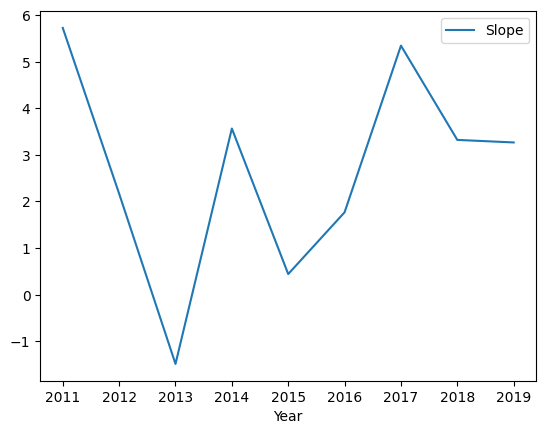

In [41]:
results_annual = pd.DataFrame(columns = ['Year', 'Intercept', 'Slope'])

for year, content in grouped_annual:
    x = content['PM2.5'].values
    y = content['EDvisit'].values
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    results_annual = results_annual.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)

results_annual['slope_significant'] = results_annual['slope_pvalue'] < 0.05
# Visualize the results_annual
results_annual.plot(x='Year', y='Slope', kind='line')

results_annual

### With Control Variables

/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/316627273.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/316627273.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/316627273.py:10: FutureWarning: The frame.append method is deprecated and will be removed fro

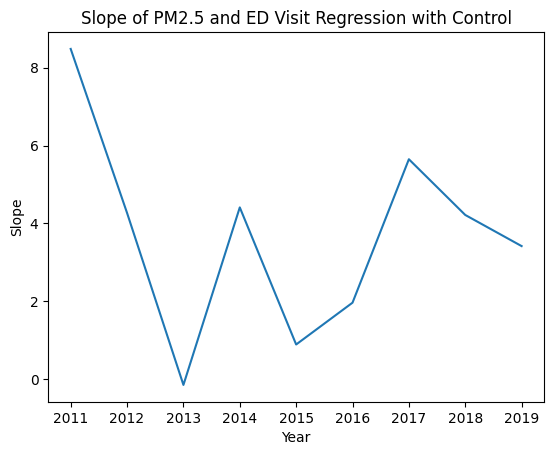

,Year,Intercept,Slope,intercept_pvalue,slope_pvalue,slope_significant
0,2011.0,4343.706964,8.484825,0.000002,0.097380,False
1,2012.0,4369.460103,4.268638,0.000009,0.350389,False
2,2013.0,3694.983466,-0.151621,0.000064,0.966940,False
3,2014.0,3538.550615,4.411316,0.000093,0.132415,False
4,2015.0,3177.306897,0.887556,0.000374,0.814844,False
5,2016.0,2744.171220,1.962265,0.001117,0.564883,False
6,2017.0,2344.361273,5.649197,0.003064,0.040792,True
7,2018.0,2627.750590,4.217185,0.000511,0.162869,False
8,2019.0,2242.765943,3.416815,0.003315,0.346724,False


In [42]:
# with regions

results_control = pd.DataFrame(columns=['Year', 'Intercept', 'Slope'])

for year, content in grouped_annual:
    x = content[['PM2.5', 'Region']].values
    y = content['EDvisit'].values
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)

results_control['slope_significant'] = results_control['slope_pvalue'] < 0.05

# Visualize the results_control
plt.plot(results_control['Year'], results_control['Slope'])
plt.xlabel('Year')
plt.ylabel('Slope')
plt.title('Slope of PM2.5 and ED Visit Regression with Control')
plt.show()

# table results
results_control


/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/1599746920.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/1599746920.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/1599746920.py:10: FutureWarning: The frame.append method is deprecated and will be removed 

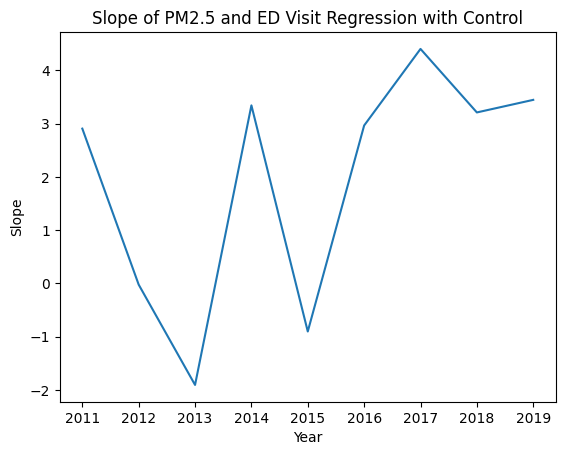

,Year,Intercept,Slope,intercept_pvalue,slope_pvalue,slope_significant
0,2011.0,-4301.552537,2.904368,0.001046,0.545367,False
1,2012.0,-3327.845032,-0.024505,0.017404,0.995454,False
2,2013.0,-3117.258143,-1.907496,0.016211,0.568460,False
3,2014.0,-3317.274753,3.340969,0.009815,0.224930,False
4,2015.0,-3054.150271,-0.904296,0.014728,0.801903,False
5,2016.0,-2862.967132,2.963046,0.019508,0.367025,False
6,2017.0,-2644.156772,4.400772,0.017556,0.093897,False
7,2018.0,-2380.776832,3.208314,0.029302,0.247508,False
8,2019.0,-2392.739296,3.444384,0.024608,0.323357,False


In [43]:
# with Economics

results_control = pd.DataFrame(columns=['Year', 'Intercept', 'Slope'])

for year, content in grouped_annual:
    x = content[['PM2.5', 'Economics']].values
    y = content['EDvisit'].values
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)

results_control['slope_significant'] = results_control['slope_pvalue'] < 0.05

# Visualize the results_control
plt.plot(results_control['Year'], results_control['Slope'])
plt.xlabel('Year')
plt.ylabel('Slope')
plt.title('Slope of PM2.5 and ED Visit Regression with Control')
plt.show()

# table results
results_control


/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/3565067272.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/3565067272.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/3565067272.py:10: FutureWarning: The frame.append method is deprecated and will be removed 

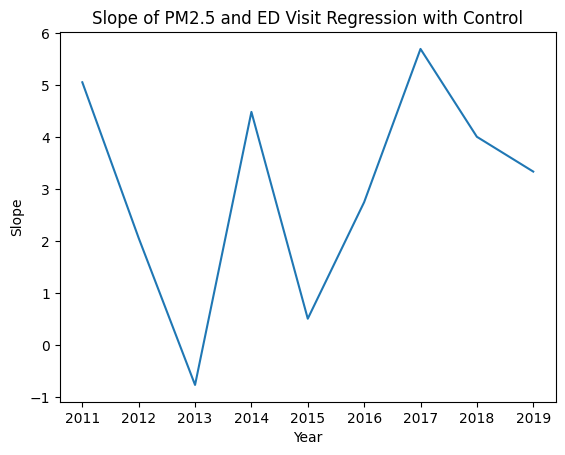

,Year,Intercept,Slope,intercept_pvalue,slope_pvalue,slope_significant
0,2011.0,-453.832055,5.051281,0.744145,0.315236,False
1,2012.0,-114.602381,2.059109,0.939241,0.641307,False
2,2013.0,128.107182,-0.761692,0.930588,0.826879,False
3,2014.0,-443.119182,4.482367,0.758382,0.119481,False
4,2015.0,224.506617,0.510306,0.870133,0.890963,False
5,2016.0,-146.946698,2.748385,0.913286,0.420419,False
6,2017.0,-554.056795,5.692068,0.657557,0.035030,True
7,2018.0,-469.450878,4.004494,0.703357,0.162454,False
8,2019.0,-148.086880,3.336233,0.898770,0.352664,False


In [44]:
# with population density

results_control = pd.DataFrame(columns=['Year', 'Intercept', 'Slope'])

for year, content in grouped_annual:
    x = content[['PM2.5', 'Population']].values
    y = content['EDvisit'].values
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)

results_control['slope_significant'] = results_control['slope_pvalue'] < 0.05

# Visualize the results_control
plt.plot(results_control['Year'], results_control['Slope'])
plt.xlabel('Year')
plt.ylabel('Slope')
plt.title('Slope of PM2.5 and ED Visit Regression with Control')
plt.show()

# table results
results_control


/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/3902658764.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/3902658764.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)
/var/folders/53/fxfttd4j1zj9m1_p2r0_n83w0000gn/T/ipykernel_43854/3902658764.py:10: FutureWarning: The frame.append method is deprecated and will be removed 

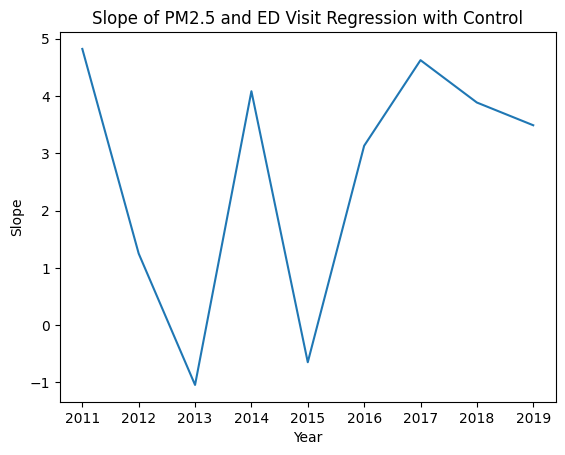

,Year,Intercept,Slope,intercept_pvalue,slope_pvalue,slope_significant
0,2011.0,-2322.685817,4.821378,0.234098,0.329973,False
1,2012.0,-2386.274326,1.249589,0.266900,0.780129,False
2,2013.0,-2447.390712,-1.043237,0.198749,0.769032,False
3,2014.0,-2576.462744,4.082940,0.162686,0.153650,False
4,2015.0,-2493.843280,-0.647295,0.162166,0.859891,False
5,2016.0,-2526.854215,3.130582,0.139690,0.347764,False
6,2017.0,-2517.939524,4.625105,0.111126,0.086112,False
7,2018.0,-2088.770765,3.885882,0.176059,0.186880,False
8,2019.0,-2310.863502,3.489023,0.125146,0.321281,False


In [45]:
# with all three

results_control = pd.DataFrame(columns=['Year', 'Intercept', 'Slope'])

for year, content in grouped_annual:
    x = content[['PM2.5', 'Region', 'Economics', 'Population']].values
    y = content['EDvisit'].values
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    results_control = results_control.append({'Year': year, 'Intercept': model.params[0], 'Slope': model.params[1], 'intercept_pvalue': model.pvalues[0], 'slope_pvalue': model.pvalues[1]}, ignore_index=True)

results_control['slope_significant'] = results_control['slope_pvalue'] < 0.05

# Visualize the results_control
plt.plot(results_control['Year'], results_control['Slope'])
plt.xlabel('Year')
plt.ylabel('Slope')
plt.title('Slope of PM2.5 and ED Visit Regression with Control')
plt.show()

# table results
results_control
